In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import kagglehub

/home/jefferyfan/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Path to dataset files: /home/jefferyfan/.cache/kagglehub/datasets/moltean/fruits/versions/11


In [4]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class FruitsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')  # Ensure 3-channel RGB
        if self.transform:
            image = self.transform(image)
        return image

# Define the dataset directory
dataset_dir = path + "/fruits-360_dataset_100x100/fruits-360/Training/Apple Red 1"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize to ensure correct dimensions
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create the dataset and DataLoader
dataset = FruitsDataset(dataset_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example: Iterate through the DataLoader
for batch_idx, images in enumerate(dataloader):
    print(f"Batch {batch_idx}, Image Tensor Shape: {images.shape}")
    break  # Load only the first batch for demonstration

Batch 0, Image Tensor Shape: torch.Size([32, 3, 100, 100])


In [5]:
class Diffusion:
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=2e-2, device='cuda'):
        self.model = model
        self.timesteps = timesteps
        self.device = device

        self.beta = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)
        #self.alpha_cumprod_prev = F.pad(self.alpha_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def forward_diffusion(self, x0, t):
        noise = torch.rand_like(x0).to(self.device)
        sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprod[t].view(-1, *[1] * (x0.dim() - 1))
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod[t].view(-1, *[1] * (x0.dim() - 1))
        xt = sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise
        return xt, noise

    def reverse_diffusion(self, xt, t):
        return self.model(xt, t)

    def compute_loss(self, x0, t):
        xt, noise = self.forward_diffusion(x0, t)
        noise_pred = self.reverse_diffusion(xt, t)
        return F.mse_loss(noise_pred, noise)

    def sample(self, shape):
        # Start with random noise
        xt = torch.randn(shape).to(self.device)
        
        # Iterate from T to 0
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.full((shape[0],), t, device=self.device, dtype=torch.long)
            
            # Predict noise
            noise_pred = self.reverse_diffusion(xt, t_tensor)
            
            # Calculate beta_t and alpha_t
            beta_t = self.beta[t]
            alpha_t = self.alpha[t]
            alpha_cumprod_t = self.alpha_cumprod[t]
            
            # Calculate mean
            coef1 = 1 / torch.sqrt(alpha_t)
            coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)
            
            # Update xt
            if t > 0:
                noise = torch.randn_like(xt)
                sigma_t = torch.sqrt(beta_t)
                xt = coef1 * (xt - coef2 * noise_pred) + sigma_t * noise
            else:
                xt = coef1 * (xt - coef2 * noise_pred)
    
        return xt

class SimpleCNNDenoisingModel(nn.Module):
    def __init__(self, channels=3, hidden_dim=64):
        super().__init__()
        
        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels + hidden_dim, hidden_dim, 3, padding=1),
            nn.BatchNorm2d(hidden_dim)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, padding=1),
            nn.BatchNorm2d(hidden_dim * 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_dim * 2, hidden_dim * 2, 3, padding=1),
            nn.BatchNorm2d(hidden_dim * 2)
        )
        
        # Decoder with skip connections
        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden_dim * 4, hidden_dim * 2, 3, padding=1),  # *4 due to skip connection
            nn.BatchNorm2d(hidden_dim * 2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(hidden_dim * 3, hidden_dim, 3, padding=1),  # *3 due to skip connection
            nn.BatchNorm2d(hidden_dim)
        )
        self.conv6 = nn.Conv2d(hidden_dim * 2, channels, 3, padding=1)  # *2 due to skip connection
        
        self.act = nn.SiLU()
        
    def forward(self, x, t):
        # Time embedding
        t = t.float().unsqueeze(-1)
        t = self.time_embed(t)
        t = t.view(-1, t.shape[1], 1, 1).repeat(1, 1, x.shape[2], x.shape[3])
        
        # Concatenate input and time embedding
        x = torch.cat([x, t], dim=1)
        
        # Encoder with skip connections
        x1 = self.act(self.conv1(x))
        x2 = self.act(self.conv2(x1))
        x3 = self.act(self.conv3(x2))
        
        # Decoder with skip connections
        x = self.act(self.conv4(torch.cat([x3, x2], dim=1)))
        x = self.act(self.conv5(torch.cat([x, x1], dim=1)))
        x = self.conv6(torch.cat([x, x1], dim=1))
        
        return x


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleCNNDenoisingModel(
    channels=3,
    hidden_dim=32  # Reduced from 64 to use less memory
).to(device)
diffusion = Diffusion(model, device=device)

epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:
from tqdm import tqdm

for epoch in range(epochs):
    epoch_loss = 0
    with tqdm(dataloader, unit="batch") as tepoch:
        for batch_idx, images in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch + 1}/{epochs}")
            x0 = images.to(device)
            t = torch.randint(0, diffusion.timesteps, (x0.size(0),), device=device)
            loss = diffusion.compute_loss(x0, t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())
    print(f"Epoch [{epoch + 1}/{epochs}], Average Loss: {epoch_loss / len(dataloader):.4f}")


Epoch 1/100: 100%|██████████| 16/16 [00:01<00:00,  8.52batch/s, loss=0.138]


Epoch [1/100], Average Loss: 0.1956


Epoch 2/100: 100%|██████████| 16/16 [00:01<00:00, 10.29batch/s, loss=0.0992]


Epoch [2/100], Average Loss: 0.1082


Epoch 3/100: 100%|██████████| 16/16 [00:01<00:00, 10.43batch/s, loss=0.0933]


Epoch [3/100], Average Loss: 0.0915


Epoch 4/100: 100%|██████████| 16/16 [00:01<00:00, 10.48batch/s, loss=0.0875]


Epoch [4/100], Average Loss: 0.0909


Epoch 5/100: 100%|██████████| 16/16 [00:01<00:00, 10.43batch/s, loss=0.0888]


Epoch [5/100], Average Loss: 0.0891


Epoch 6/100: 100%|██████████| 16/16 [00:01<00:00, 10.34batch/s, loss=0.087] 


Epoch [6/100], Average Loss: 0.0859


Epoch 7/100: 100%|██████████| 16/16 [00:01<00:00, 10.39batch/s, loss=0.0854]


Epoch [7/100], Average Loss: 0.0849


Epoch 8/100: 100%|██████████| 16/16 [00:01<00:00, 10.30batch/s, loss=0.0869]


Epoch [8/100], Average Loss: 0.0854


Epoch 9/100: 100%|██████████| 16/16 [00:01<00:00, 10.40batch/s, loss=0.085] 


Epoch [9/100], Average Loss: 0.0847


Epoch 10/100: 100%|██████████| 16/16 [00:01<00:00, 10.27batch/s, loss=0.084] 


Epoch [10/100], Average Loss: 0.0842


Epoch 11/100: 100%|██████████| 16/16 [00:01<00:00, 10.52batch/s, loss=0.0839]


Epoch [11/100], Average Loss: 0.0842


Epoch 12/100: 100%|██████████| 16/16 [00:01<00:00, 10.32batch/s, loss=0.0867]


Epoch [12/100], Average Loss: 0.0842


Epoch 13/100: 100%|██████████| 16/16 [00:01<00:00, 10.39batch/s, loss=0.0836]


Epoch [13/100], Average Loss: 0.0834


Epoch 14/100: 100%|██████████| 16/16 [00:01<00:00, 10.38batch/s, loss=0.0846]


Epoch [14/100], Average Loss: 0.0839


Epoch 15/100: 100%|██████████| 16/16 [00:01<00:00, 10.25batch/s, loss=0.0834]


Epoch [15/100], Average Loss: 0.0833


Epoch 16/100: 100%|██████████| 16/16 [00:01<00:00, 10.43batch/s, loss=0.0831]


Epoch [16/100], Average Loss: 0.0833


Epoch 17/100: 100%|██████████| 16/16 [00:01<00:00, 10.32batch/s, loss=0.0824]


Epoch [17/100], Average Loss: 0.0828


Epoch 18/100: 100%|██████████| 16/16 [00:01<00:00, 10.32batch/s, loss=0.0821]


Epoch [18/100], Average Loss: 0.0822


Epoch 19/100: 100%|██████████| 16/16 [00:01<00:00, 10.37batch/s, loss=0.081] 


Epoch [19/100], Average Loss: 0.0815


Epoch 20/100: 100%|██████████| 16/16 [00:01<00:00, 10.50batch/s, loss=0.0823]


Epoch [20/100], Average Loss: 0.0809


Epoch 21/100: 100%|██████████| 16/16 [00:01<00:00, 10.12batch/s, loss=0.0769]


Epoch [21/100], Average Loss: 0.0788


Epoch 22/100: 100%|██████████| 16/16 [00:01<00:00, 10.18batch/s, loss=0.0963]


Epoch [22/100], Average Loss: 0.0766


Epoch 23/100: 100%|██████████| 16/16 [00:01<00:00, 10.10batch/s, loss=0.0693]


Epoch [23/100], Average Loss: 0.0734


Epoch 24/100: 100%|██████████| 16/16 [00:01<00:00, 10.19batch/s, loss=0.068] 


Epoch [24/100], Average Loss: 0.0682


Epoch 25/100: 100%|██████████| 16/16 [00:01<00:00, 10.24batch/s, loss=0.0593]


Epoch [25/100], Average Loss: 0.0630


Epoch 26/100: 100%|██████████| 16/16 [00:01<00:00, 10.25batch/s, loss=0.0554]


Epoch [26/100], Average Loss: 0.0576


Epoch 27/100: 100%|██████████| 16/16 [00:01<00:00, 10.15batch/s, loss=0.0558]


Epoch [27/100], Average Loss: 0.0529


Epoch 28/100: 100%|██████████| 16/16 [00:01<00:00, 10.22batch/s, loss=0.0489]


Epoch [28/100], Average Loss: 0.0488


Epoch 29/100: 100%|██████████| 16/16 [00:01<00:00, 10.21batch/s, loss=0.045] 


Epoch [29/100], Average Loss: 0.0447


Epoch 30/100: 100%|██████████| 16/16 [00:01<00:00, 10.20batch/s, loss=0.0385]


Epoch [30/100], Average Loss: 0.0419


Epoch 31/100: 100%|██████████| 16/16 [00:01<00:00, 10.12batch/s, loss=0.0408]


Epoch [31/100], Average Loss: 0.0372


Epoch 32/100: 100%|██████████| 16/16 [00:01<00:00, 10.34batch/s, loss=0.0298]


Epoch [32/100], Average Loss: 0.0344


Epoch 33/100: 100%|██████████| 16/16 [00:01<00:00, 10.33batch/s, loss=0.0319]


Epoch [33/100], Average Loss: 0.0298


Epoch 34/100: 100%|██████████| 16/16 [00:01<00:00, 10.30batch/s, loss=0.0258]


Epoch [34/100], Average Loss: 0.0296


Epoch 35/100: 100%|██████████| 16/16 [00:01<00:00, 10.30batch/s, loss=0.0216]


Epoch [35/100], Average Loss: 0.0248


Epoch 36/100: 100%|██████████| 16/16 [00:01<00:00, 10.27batch/s, loss=0.023] 


Epoch [36/100], Average Loss: 0.0254


Epoch 37/100: 100%|██████████| 16/16 [00:01<00:00, 10.43batch/s, loss=0.0281]


Epoch [37/100], Average Loss: 0.0231


Epoch 38/100: 100%|██████████| 16/16 [00:01<00:00, 10.29batch/s, loss=0.0272]


Epoch [38/100], Average Loss: 0.0231


Epoch 39/100: 100%|██████████| 16/16 [00:01<00:00, 10.30batch/s, loss=0.0168]


Epoch [39/100], Average Loss: 0.0192


Epoch 40/100: 100%|██████████| 16/16 [00:01<00:00, 10.38batch/s, loss=0.0175]


Epoch [40/100], Average Loss: 0.0197


Epoch 41/100: 100%|██████████| 16/16 [00:01<00:00, 10.31batch/s, loss=0.0185]


Epoch [41/100], Average Loss: 0.0182


Epoch 42/100: 100%|██████████| 16/16 [00:01<00:00, 10.35batch/s, loss=0.0192]


Epoch [42/100], Average Loss: 0.0178


Epoch 43/100: 100%|██████████| 16/16 [00:01<00:00, 10.42batch/s, loss=0.021] 


Epoch [43/100], Average Loss: 0.0195


Epoch 44/100: 100%|██████████| 16/16 [00:01<00:00, 10.40batch/s, loss=0.0159]


Epoch [44/100], Average Loss: 0.0174


Epoch 45/100: 100%|██████████| 16/16 [00:01<00:00, 10.28batch/s, loss=0.0256]


Epoch [45/100], Average Loss: 0.0183


Epoch 46/100: 100%|██████████| 16/16 [00:01<00:00, 10.15batch/s, loss=0.0157]


Epoch [46/100], Average Loss: 0.0177


Epoch 47/100: 100%|██████████| 16/16 [00:01<00:00, 10.34batch/s, loss=0.0177]


Epoch [47/100], Average Loss: 0.0171


Epoch 48/100: 100%|██████████| 16/16 [00:01<00:00, 10.37batch/s, loss=0.0145]


Epoch [48/100], Average Loss: 0.0163


Epoch 49/100: 100%|██████████| 16/16 [00:01<00:00, 10.42batch/s, loss=0.014] 


Epoch [49/100], Average Loss: 0.0153


Epoch 50/100: 100%|██████████| 16/16 [00:01<00:00, 10.32batch/s, loss=0.0221]


Epoch [50/100], Average Loss: 0.0176


Epoch 51/100: 100%|██████████| 16/16 [00:01<00:00, 10.31batch/s, loss=0.0163]


Epoch [51/100], Average Loss: 0.0169


Epoch 52/100: 100%|██████████| 16/16 [00:01<00:00, 10.36batch/s, loss=0.0148]


Epoch [52/100], Average Loss: 0.0153


Epoch 53/100: 100%|██████████| 16/16 [00:01<00:00, 10.26batch/s, loss=0.0214]


Epoch [53/100], Average Loss: 0.0157


Epoch 54/100: 100%|██████████| 16/16 [00:01<00:00, 10.15batch/s, loss=0.0148]


Epoch [54/100], Average Loss: 0.0143


Epoch 55/100: 100%|██████████| 16/16 [00:01<00:00, 10.40batch/s, loss=0.0119]


Epoch [55/100], Average Loss: 0.0139


Epoch 56/100: 100%|██████████| 16/16 [00:01<00:00, 10.32batch/s, loss=0.0123]


Epoch [56/100], Average Loss: 0.0154


Epoch 57/100: 100%|██████████| 16/16 [00:01<00:00, 10.34batch/s, loss=0.0117]


Epoch [57/100], Average Loss: 0.0142


Epoch 58/100: 100%|██████████| 16/16 [00:01<00:00, 10.31batch/s, loss=0.0136]


Epoch [58/100], Average Loss: 0.0134


Epoch 59/100: 100%|██████████| 16/16 [00:01<00:00, 10.50batch/s, loss=0.0126]


Epoch [59/100], Average Loss: 0.0134


Epoch 60/100: 100%|██████████| 16/16 [00:01<00:00, 10.30batch/s, loss=0.0184]


Epoch [60/100], Average Loss: 0.0145


Epoch 61/100: 100%|██████████| 16/16 [00:01<00:00, 10.33batch/s, loss=0.0145]


Epoch [61/100], Average Loss: 0.0143


Epoch 62/100: 100%|██████████| 16/16 [00:01<00:00, 10.36batch/s, loss=0.0133]


Epoch [62/100], Average Loss: 0.0136


Epoch 63/100: 100%|██████████| 16/16 [00:01<00:00, 10.45batch/s, loss=0.0172]


Epoch [63/100], Average Loss: 0.0137


Epoch 64/100: 100%|██████████| 16/16 [00:01<00:00, 10.46batch/s, loss=0.0119]


Epoch [64/100], Average Loss: 0.0132


Epoch 65/100: 100%|██████████| 16/16 [00:01<00:00, 10.37batch/s, loss=0.0157]


Epoch [65/100], Average Loss: 0.0130


Epoch 66/100: 100%|██████████| 16/16 [00:01<00:00, 10.38batch/s, loss=0.0122]


Epoch [66/100], Average Loss: 0.0125


Epoch 67/100: 100%|██████████| 16/16 [00:01<00:00, 10.36batch/s, loss=0.011] 


Epoch [67/100], Average Loss: 0.0118


Epoch 68/100: 100%|██████████| 16/16 [00:01<00:00, 10.40batch/s, loss=0.0133]


Epoch [68/100], Average Loss: 0.0134


Epoch 69/100: 100%|██████████| 16/16 [00:01<00:00, 10.22batch/s, loss=0.0123]


Epoch [69/100], Average Loss: 0.0135


Epoch 70/100: 100%|██████████| 16/16 [00:01<00:00, 10.34batch/s, loss=0.0112]


Epoch [70/100], Average Loss: 0.0137


Epoch 71/100: 100%|██████████| 16/16 [00:01<00:00, 10.19batch/s, loss=0.0161]


Epoch [71/100], Average Loss: 0.0137


Epoch 72/100: 100%|██████████| 16/16 [00:01<00:00, 10.36batch/s, loss=0.0163] 


Epoch [72/100], Average Loss: 0.0128


Epoch 73/100: 100%|██████████| 16/16 [00:01<00:00, 10.34batch/s, loss=0.00974]


Epoch [73/100], Average Loss: 0.0118


Epoch 74/100: 100%|██████████| 16/16 [00:01<00:00, 10.34batch/s, loss=0.0112]


Epoch [74/100], Average Loss: 0.0135


Epoch 75/100: 100%|██████████| 16/16 [00:01<00:00, 10.41batch/s, loss=0.0121]


Epoch [75/100], Average Loss: 0.0119


Epoch 76/100: 100%|██████████| 16/16 [00:01<00:00, 10.24batch/s, loss=0.00947]


Epoch [76/100], Average Loss: 0.0129


Epoch 77/100: 100%|██████████| 16/16 [00:01<00:00, 10.17batch/s, loss=0.0109] 


Epoch [77/100], Average Loss: 0.0110


Epoch 78/100: 100%|██████████| 16/16 [00:01<00:00, 10.25batch/s, loss=0.0128] 


Epoch [78/100], Average Loss: 0.0120


Epoch 79/100: 100%|██████████| 16/16 [00:01<00:00, 10.33batch/s, loss=0.0111]


Epoch [79/100], Average Loss: 0.0122


Epoch 80/100: 100%|██████████| 16/16 [00:01<00:00, 10.29batch/s, loss=0.0126]


Epoch [80/100], Average Loss: 0.0118


Epoch 81/100: 100%|██████████| 16/16 [00:01<00:00, 10.13batch/s, loss=0.0126] 


Epoch [81/100], Average Loss: 0.0135


Epoch 82/100: 100%|██████████| 16/16 [00:01<00:00, 10.22batch/s, loss=0.0141]


Epoch [82/100], Average Loss: 0.0122


Epoch 83/100: 100%|██████████| 16/16 [00:01<00:00, 10.40batch/s, loss=0.00929]


Epoch [83/100], Average Loss: 0.0114


Epoch 84/100: 100%|██████████| 16/16 [00:01<00:00, 10.39batch/s, loss=0.0173] 


Epoch [84/100], Average Loss: 0.0130


Epoch 85/100: 100%|██████████| 16/16 [00:01<00:00, 10.41batch/s, loss=0.0145] 


Epoch [85/100], Average Loss: 0.0125


Epoch 86/100: 100%|██████████| 16/16 [00:01<00:00, 10.27batch/s, loss=0.0294]


Epoch [86/100], Average Loss: 0.0153


Epoch 87/100: 100%|██████████| 16/16 [00:01<00:00, 10.22batch/s, loss=0.0137]


Epoch [87/100], Average Loss: 0.0134


Epoch 88/100: 100%|██████████| 16/16 [00:01<00:00, 10.41batch/s, loss=0.0106] 


Epoch [88/100], Average Loss: 0.0110


Epoch 89/100: 100%|██████████| 16/16 [00:01<00:00, 10.28batch/s, loss=0.0253] 


Epoch [89/100], Average Loss: 0.0145


Epoch 90/100: 100%|██████████| 16/16 [00:01<00:00, 10.09batch/s, loss=0.0136]


Epoch [90/100], Average Loss: 0.0124


Epoch 91/100: 100%|██████████| 16/16 [00:01<00:00, 10.28batch/s, loss=0.0151]


Epoch [91/100], Average Loss: 0.0119


Epoch 92/100: 100%|██████████| 16/16 [00:01<00:00, 10.15batch/s, loss=0.0202] 


Epoch [92/100], Average Loss: 0.0123


Epoch 93/100: 100%|██████████| 16/16 [00:01<00:00, 10.24batch/s, loss=0.0114] 


Epoch [93/100], Average Loss: 0.0113


Epoch 94/100: 100%|██████████| 16/16 [00:01<00:00, 10.36batch/s, loss=0.017] 


Epoch [94/100], Average Loss: 0.0117


Epoch 95/100: 100%|██████████| 16/16 [00:01<00:00, 10.40batch/s, loss=0.00879]


Epoch [95/100], Average Loss: 0.0102


Epoch 96/100: 100%|██████████| 16/16 [00:01<00:00, 10.37batch/s, loss=0.00984]


Epoch [96/100], Average Loss: 0.0108


Epoch 97/100: 100%|██████████| 16/16 [00:01<00:00, 10.38batch/s, loss=0.01]   


Epoch [97/100], Average Loss: 0.0108


Epoch 98/100: 100%|██████████| 16/16 [00:01<00:00, 10.22batch/s, loss=0.0108] 


Epoch [98/100], Average Loss: 0.0103


Epoch 99/100: 100%|██████████| 16/16 [00:01<00:00, 10.43batch/s, loss=0.0152] 


Epoch [99/100], Average Loss: 0.0118


Epoch 100/100: 100%|██████████| 16/16 [00:01<00:00, 10.35batch/s, loss=0.0108] 

Epoch [100/100], Average Loss: 0.0118


In [8]:
model.cpu()  # Move model to CPU
torch.cuda.empty_cache()  # Clear CUDA cache
del diffusion  # Remove diffusion object

# If you need to generate samples later, you can move the model back to GPU:
model.to(device)
diffusion = Diffusion(model, device=device)

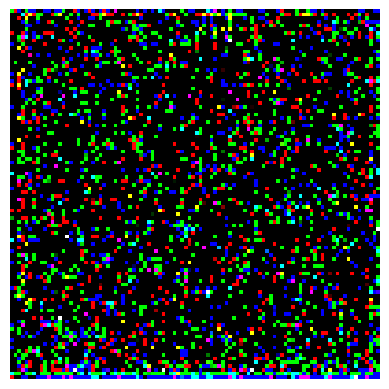

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize a tensor
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean, device=tensor.device).view(-1, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(-1, 1, 1)
    return torch.clamp(tensor * std + mean, 0, 1)

def generate_sample(diffusion, shape):
    with torch.no_grad():
        sample = diffusion.sample(shape)
        sample = sample.cpu()  # Move to CPU immediately
    torch.cuda.empty_cache()
    return sample

# When generating samples:
sample_shape = (1, 3, 100, 100)
generated_sample = generate_sample(diffusion, sample_shape)

# Denormalize
mean = [0.5, 0.5, 0.5]  # Same values used in your transform
std = [0.5, 0.5, 0.5]   # Same values used in your transform
sample_denorm = denormalize(generated_sample, mean, std)

# Convert to numpy and proper format for plotting
sample_np = sample_denorm.detach().cpu().numpy()
sample_np = np.transpose(sample_np[0], (1, 2, 0))  # Change from (B, C, H, W) to (H, W, C)
sample_np = np.clip(sample_np, 0, 1)  # Ensure values are in [0, 1]

# Plot
plt.imshow(sample_np)
plt.axis('off')
plt.show()
